### Pre-requisites
For speed, we are going to import `fastbook` here; but be aware that some functions are defined there, and should be extracted eventually.

In [44]:
#!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data
One way to get images is from DuckDuckGo.

In [45]:
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls), urls[10]

(100,
 'https://media.spokesman.com/photos/2018/08/18/Grizzly_Bears_Montana.JPG.jpg')

`download_url()` will create the directories if needed

In [46]:
download_url(urls[0], 'downloads/bear.jpg')


Path('downloads/bear.jpg')

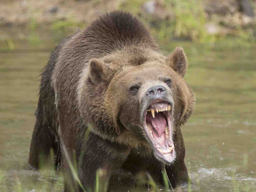

In [47]:
im = Image.open('downloads/bear.jpg')
im.to_thumb(256,256)

Now lets bring a bunch of images and classify them in folders:

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f"{o} bear", max_images=100)
        download_images(dest=dest, urls=results)

Now we will get the local path to all of the image files:

In [55]:
fns = get_image_files(path)
fns

(#283) [Path('bears/teddy/00000023.jpg'),Path('bears/teddy/00000090.jpeg'),Path('bears/teddy/00000008.jpg'),Path('bears/teddy/00000004.jpeg'),Path('bears/teddy/00000070.jpg'),Path('bears/teddy/00000045.jpg'),Path('bears/teddy/00000049.jpg'),Path('bears/teddy/00000097.jpg'),Path('bears/teddy/00000061.jpg'),Path('bears/teddy/00000001.jpg')...]

Verify Images: find those that cannot  be opened, so they can be removed from the dataset

In [56]:
failed = verify_images(fns)
failed

(#4) [Path('bears/teddy/00000015.jpg'),Path('bears/grizzly/00000023.jpg'),Path('bears/grizzly/00000064.jpg'),Path('bears/grizzly/00000081.jpg')]

Remove those images from the dataset:

In [57]:
failed.map(Path.unlink);

We can verify again... it should be empty this time.

In [60]:
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#0) []

We ultimately want to generate a DataLoader?

In [61]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [63]:
dls = bears.dataloaders(path)
dls